# Figures for Paper

This notebook assembles results for visualization purposes.

In [2]:
# Classic python
import pandas as pd
import numpy as np
from copy import deepcopy
import os
import sys
from importlib import reload
from scipy.stats import zscore
from scipy.stats import entropy
import scipy.io
import scipy
import textwrap
from scipy import sparse
import importlib
from itertools import product
import pickle  # saving outputs
import numbers
from mpl_toolkits.mplot3d import Axes3D  # Import Axes3D module
import networkx as nx

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 7, 3

# Notebook
from nb_util import *

# package in development
# from scr import bioObsv
# from scr.dataPrep import *
# from scr.visualization import *

## Estimation on Hasnain Data

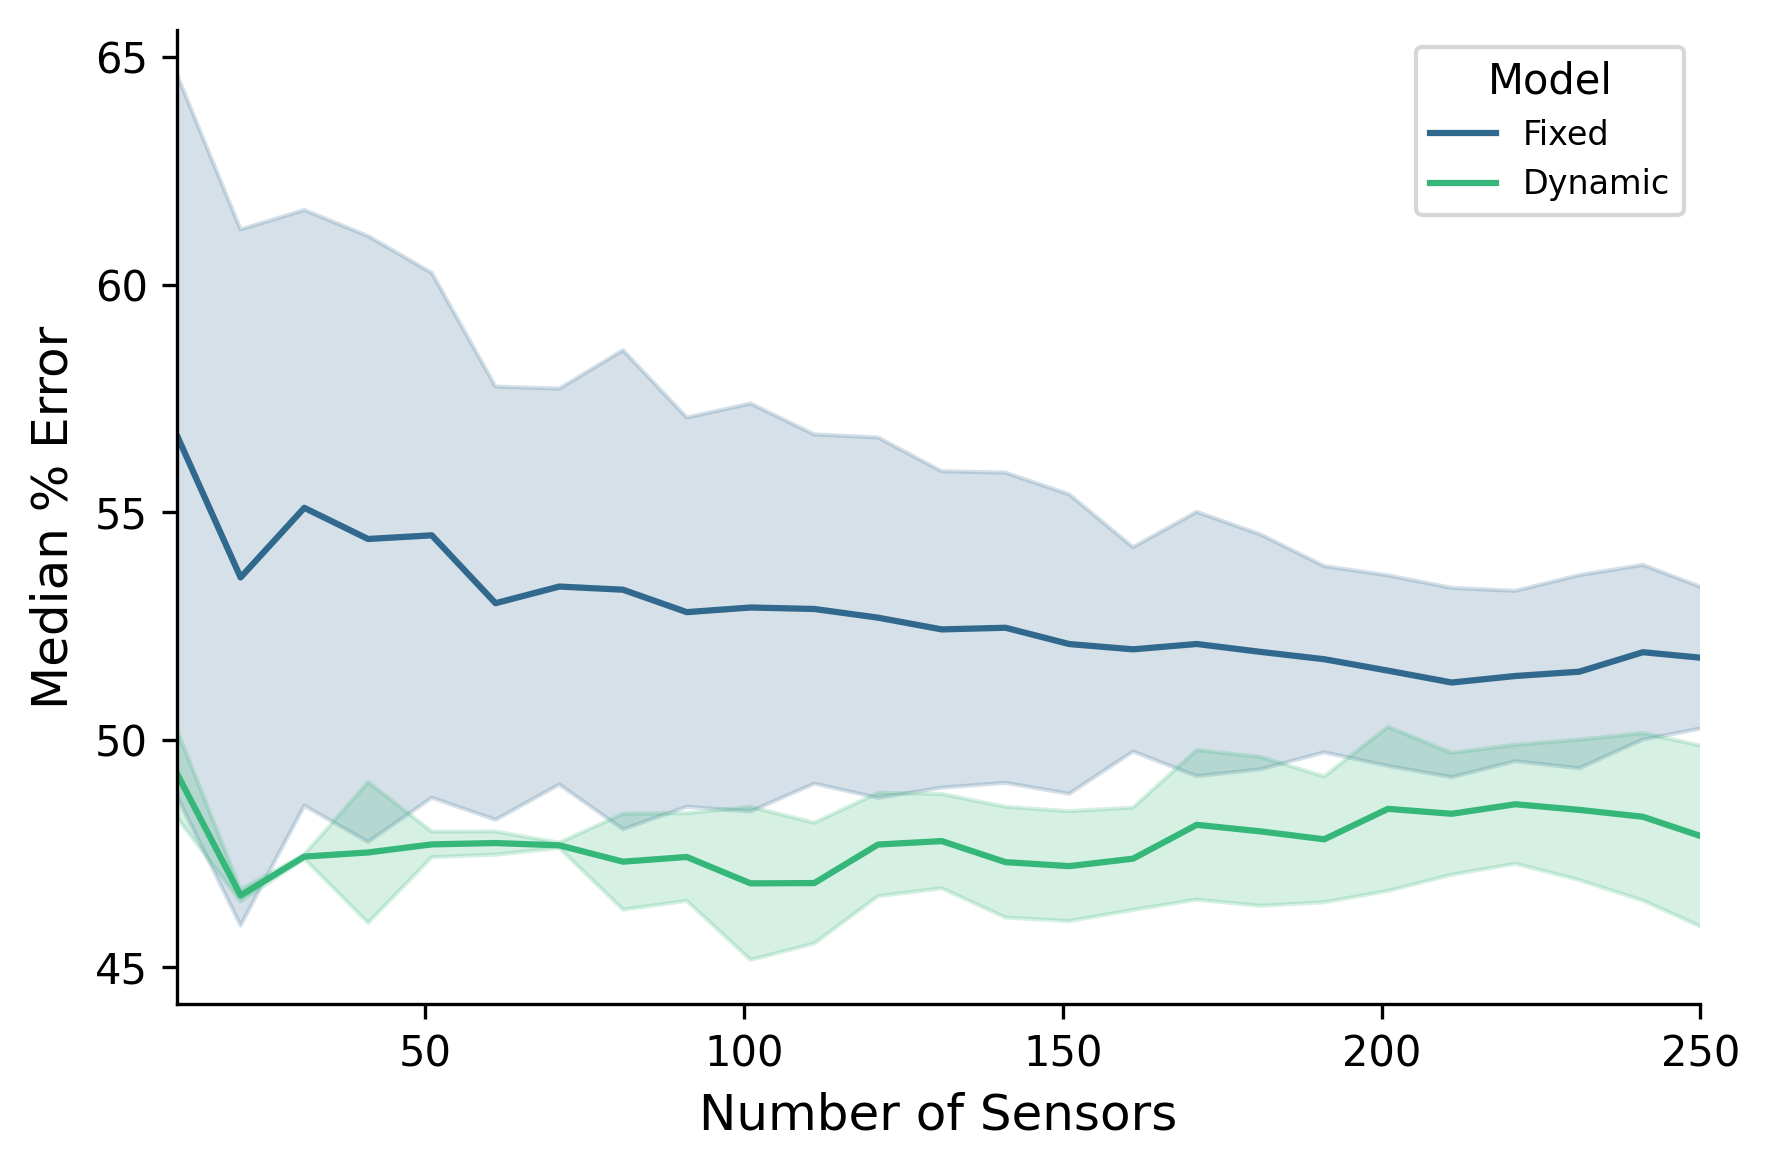

In [5]:
rdf1 = pd.read_csv('/nfs/turbo/umms-indikar/Joshua/obsvArticle/results/hasnain_estimation_fixed_v_dynamic_res1.csv')
rdf2 = pd.read_csv('/nfs/turbo/umms-indikar/Joshua/obsvArticle/results/hasnain_estimation_fixed_v_dynamic_res2.csv')
rdf1

plt.figure(figsize=(6, 4), dpi=300)
pdf = rdf1[rdf1['numSensors'] > 1]
# Adjust marker size and color palette
sns.lineplot(
    data=pdf,
    x='numSensors',
    y='median % error',
    hue='model',
    palette='viridis'
)
plt.xlabel('Number of Sensors', fontsize=12)
plt.ylabel('Median % Error', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Model', fontsize=8)
# plt.grid(True)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(5))
# plt.xlim(11, 350)
plt.xlim([11, 250])
plt.tight_layout()
sns.despine()
plt.show()

## Functional Observability

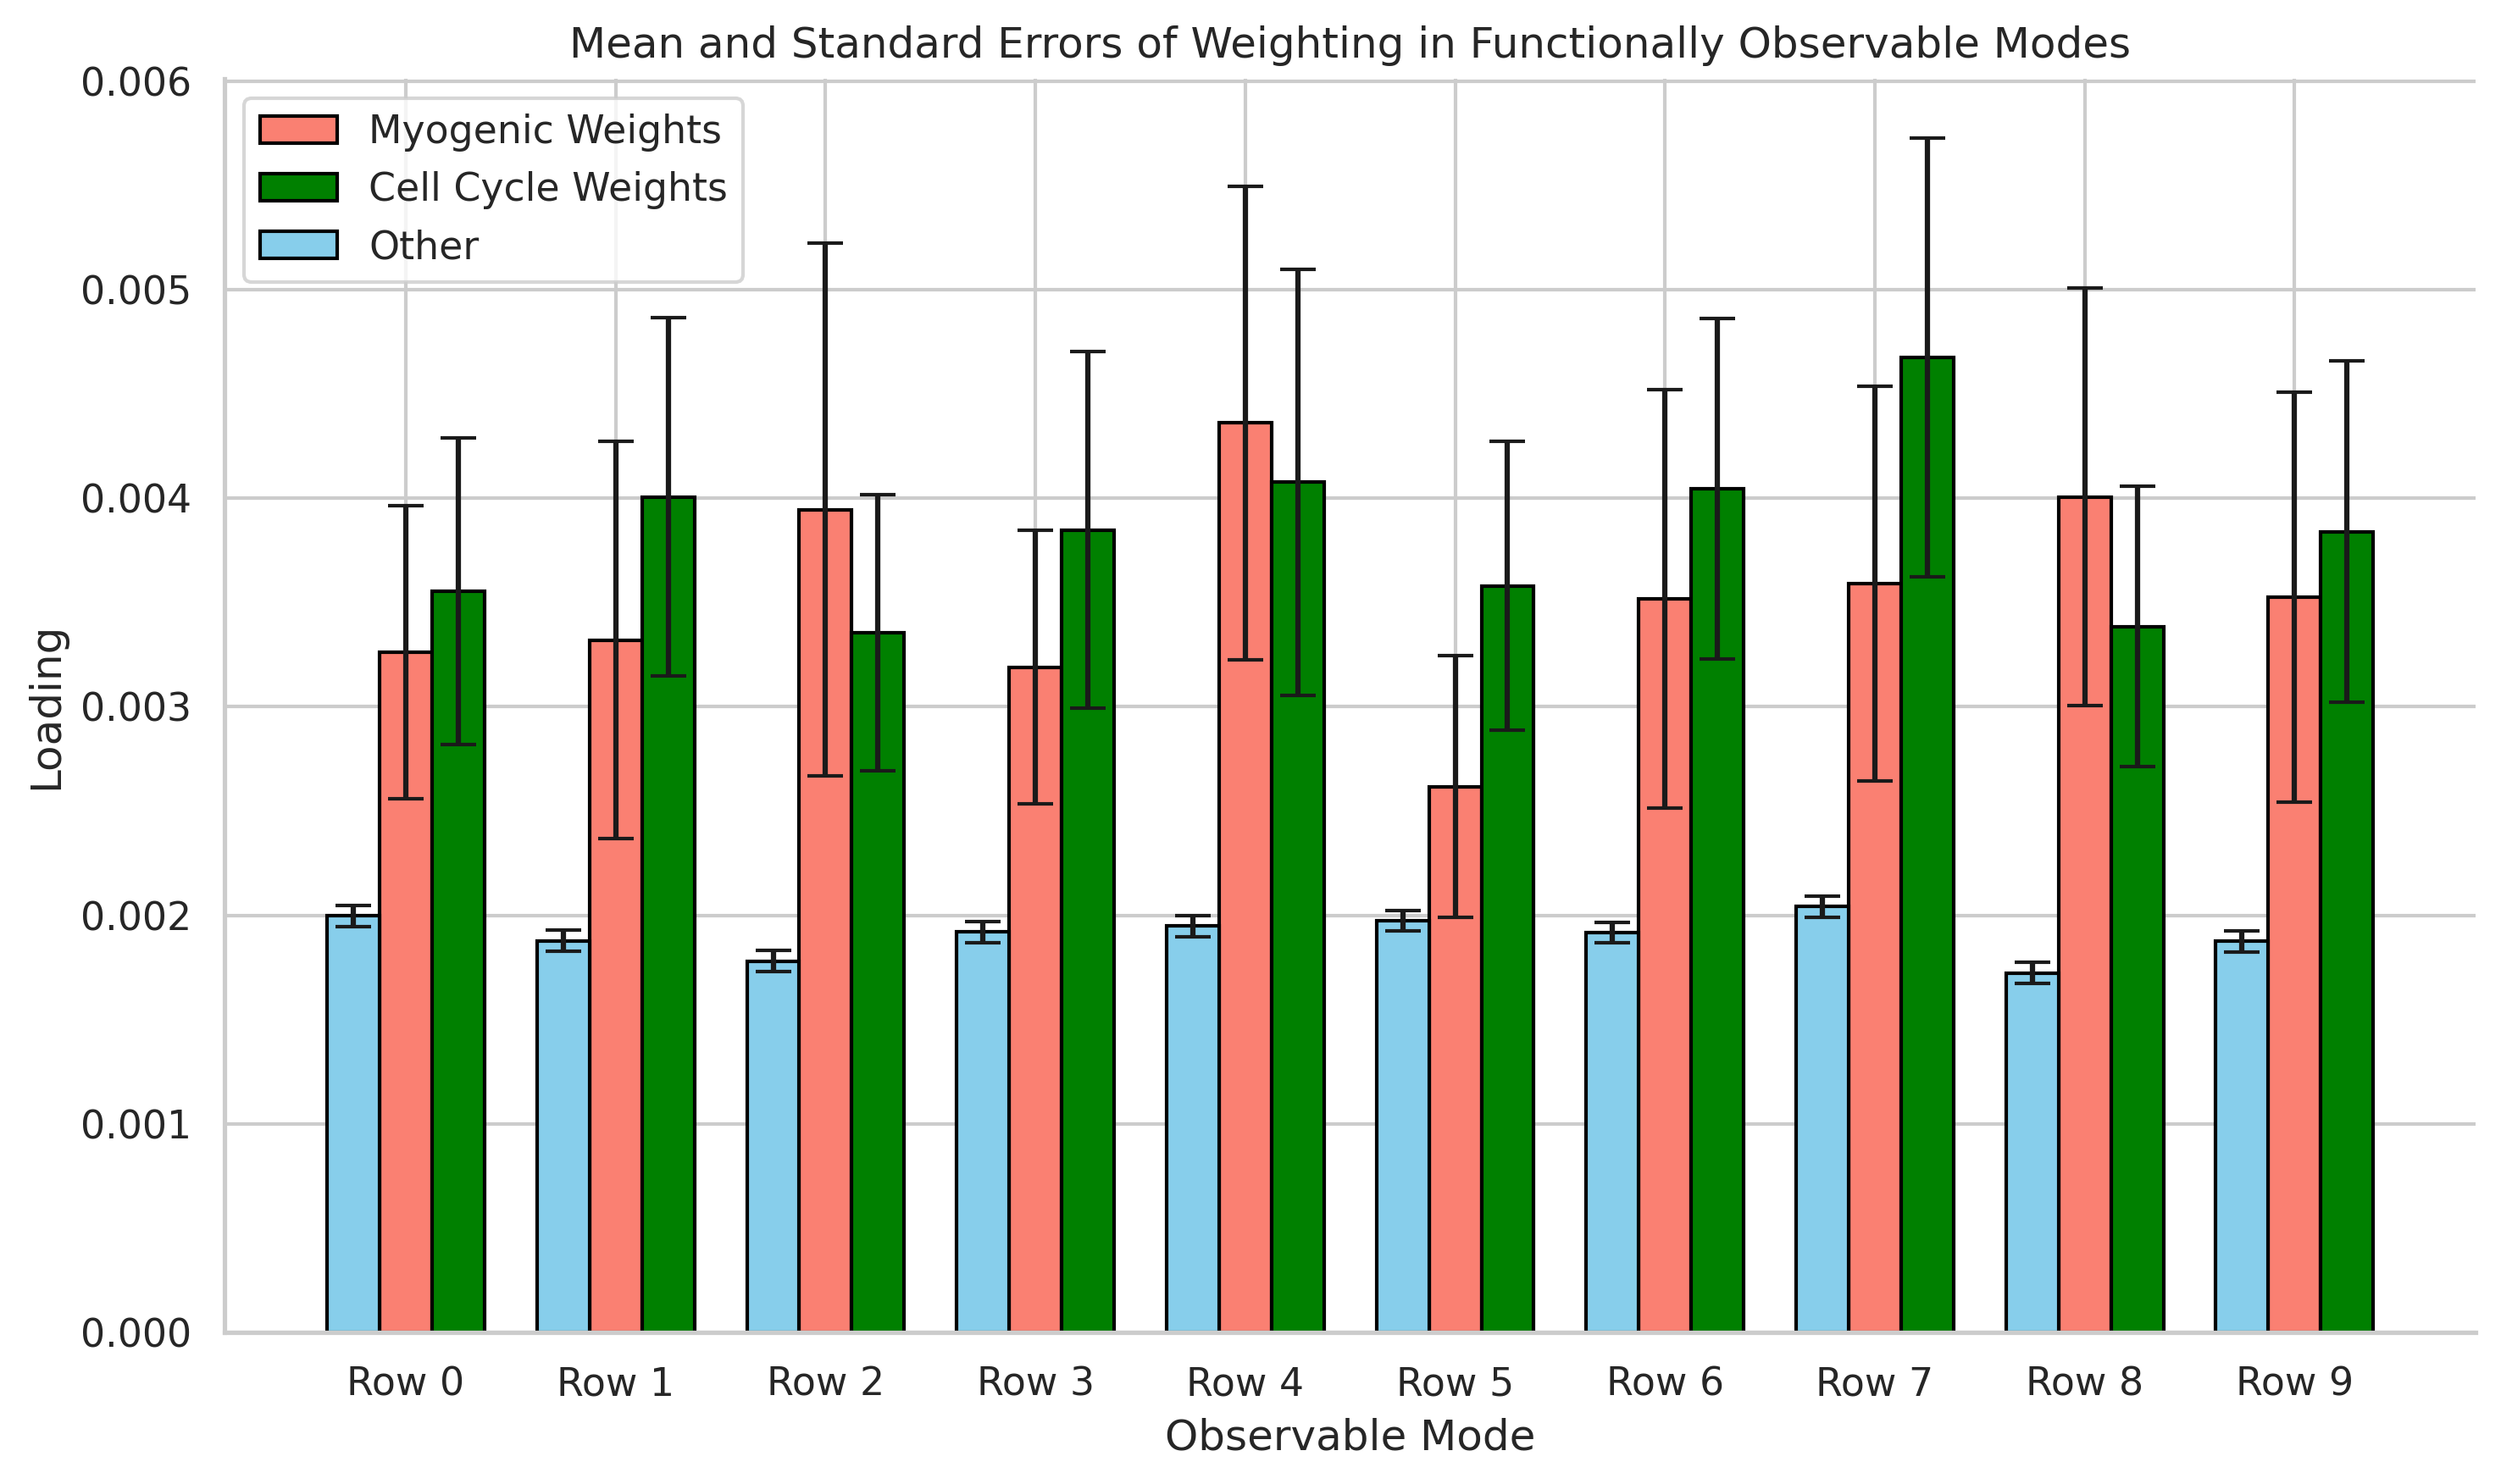

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Load data from the .csv file
df = pd.read_csv('data/functional_obsv_data.csv')

# Extract data for plotting
x = np.arange(len(df))  # x locations for the groups
width = 0.25  # Width of the bars

# Extract means and stds from the DataFrame
Vt_means = df['Vt_means']
Vt_stds = df['Vt_serr']
myo_means = df['myo_means']
myo_stds = df['myo_serr']
cc_means = df['cc_means']
cc_stds = df['cc_serr']

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars with error bars
bars2 = ax.bar(x, myo_means, width, yerr=myo_stds, label='Myogenic Weights', color='salmon', capsize=5, edgecolor='black')
bars3 = ax.bar(x + width, cc_means, width, yerr=cc_stds, label='Cell Cycle Weights', color='green', capsize=5, edgecolor='black')
bars1 = ax.bar(x - width, Vt_means, width, yerr=Vt_stds, label='Other', color='skyblue', capsize=5, edgecolor='black')

# Add labels and title
ax.set_xlabel('Observable Mode')
ax.set_ylabel('Loading')
ax.set_title('Mean and Standard Errors of Weighting in Functionally Observable Modes')
ax.set_xticks(x)
ax.set_xticklabels(df['Row'])
ax.legend()

plt.tight_layout()
sns.despine()
plt.show()


## Sensor Distribution across Chromosomes

In [6]:
################################
################################
#
#       get gene names
#
################################
################################
# 2015 data
data_path_2015 = f"/nfs/turbo/umms-indikar/shared/projects/cell_cycle/data/chen_2015_data/RNA_pipeline_ouputs/countMatrix/counts.raw.txt"
gene_path_2015 = f"/nfs/turbo/umms-indikar/shared/projects/cell_cycle/data/chen_2015_data/RNA_pipeline_ouputs/references/geneTable.csv"

# Load the raw expression
df_2015 = pd.read_csv(data_path_2015, index_col=0)

# remove MT and ribosomal genes
all_genes_2015 = df_2015.index.to_list()
mt_genes_2015 = [x for x in all_genes_2015 if x.startswith('MT-')]
rp_genes_2015 = [x for x in all_genes_2015 if x.startswith('RP')]
df_2015 = df_2015.drop(mt_genes_2015) # drop MT genes
df_2015 = df_2015.drop(rp_genes_2015) # drop ribosomal genes

# rewrite the list for removed genes
gene_names_2015 = df_2015.index.to_list()

################################
################################
#
#       load gtf file
#
################################
################################
# gene_path_2015 = f"/nfs/turbo/umms-indikar/shared/projects/cell_cycle/data/RNA_pipeline_ouputs/references/geneTable.csv"
gtf = pd.read_csv(gene_path_2015)
gtf = gtf[gtf['gene_name'].isin(gene_names_2015)]
gtf.drop_duplicates(subset='gene_name', inplace=True)
gtf = gtf[gtf['Feature'] == 'gene']
gtf = gtf[gtf['gene_biotype'] == 'protein_coding'].reset_index(drop=False)
gene_names_2015 = [gene for gene in gene_names_2015 if gene in list(gtf['gene_name'])]

# set which data from gtf should be kept
gtf = gtf[['gene_name', 'Chromosome', 'Start', 'End']].drop_duplicates()
gtf['Length'] = gtf['End'] - gtf['Start']
chromLengths = {}
for x in gtf.groupby('Chromosome'):
    chromLengths[x[0]] = max(x[1]['End'].values)
# absolut locations are used to sort genes. Must remember these are not truely ordinal between chromosomes
absLocation = {}
absLoc = 0
for chrom, lens in chromLengths.items():
    absLocation[chrom] = absLoc
    absLoc += lens
gtf['Abs Location'] = gtf['Start']
for index, row in gtf.iterrows():
    gtf.loc[index, 'Abs Location'] += absLocation[gtf.loc[index, 'Chromosome']]
gtf = gtf.set_index('gene_name')
gtf = gtf.rename(columns={'Chromosome': 'chrom', 'Start': 'start', 'End': 'end', 'Length': 'length', 'Abs Location': 'abs_location'})

gtf['chrom'] = gtf['chrom'].apply(str)
chromGtf = list(gtf.chrom.values)

gtf

 /tmp/ipykernel_3900243/3255638363.py:33: DtypeWarning:Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.


,chrom,start,end,length,abs_location
gene_name,,,,,
ATAD3B,1,1471764,1497848,26084,1471764
PRDM16,1,3069167,3438621,369454,3069167
SKI,1,2228318,2310213,81895,2228318
PEX14,1,10472287,10630758,158471,10472287
PLCH2,1,2425979,2505532,79553,2425979
...,...,...,...,...,...
DAZ3,Y,24763068,24813492,50424,3101131169
DAZ1,Y,23129354,23199010,69656,3099497455
AMELY,Y,6865917,6911752,45835,3083234018


In [7]:
res = {
    'chrom':[],
    'count':[],
    ' ':[]
}
for chrom in list(np.arange(1,23)) + ['X', 'Y']:
    res['chrom'].append(chrom)
    res['count'].append(chromGtf.count(str(chrom)))
    res[' '].append('True Distribution')
    
cdf = pd.DataFrame(res)
cdf['% of Genes'] = cdf['count'] / cdf['count'].sum()

In [8]:
dataPath = '/nfs/turbo/umms-indikar/Joshua/bioObsv/notebooks/obsvArticle/dataProcessing/amit/'
files = ['sensorSet_2015_raw_full_DMD.xls',
         'sensorSet_2015_raw_full_timeVarying.xls',
         'sensorSet_2015_raw_full_DMD_structCst.xls',
         'sensorSet_2015_raw_full_timeVarying_structCst.xls'
        ]
fileTitles = [
            'DMD (unconstrained)',
            'DGC (unconstrained)',
            'DMD (structure guided)',
            'DGC (structure guided)',
        ]
# Sheet1 is time variant sensors
# Sheet2 is time invariant sensors

474


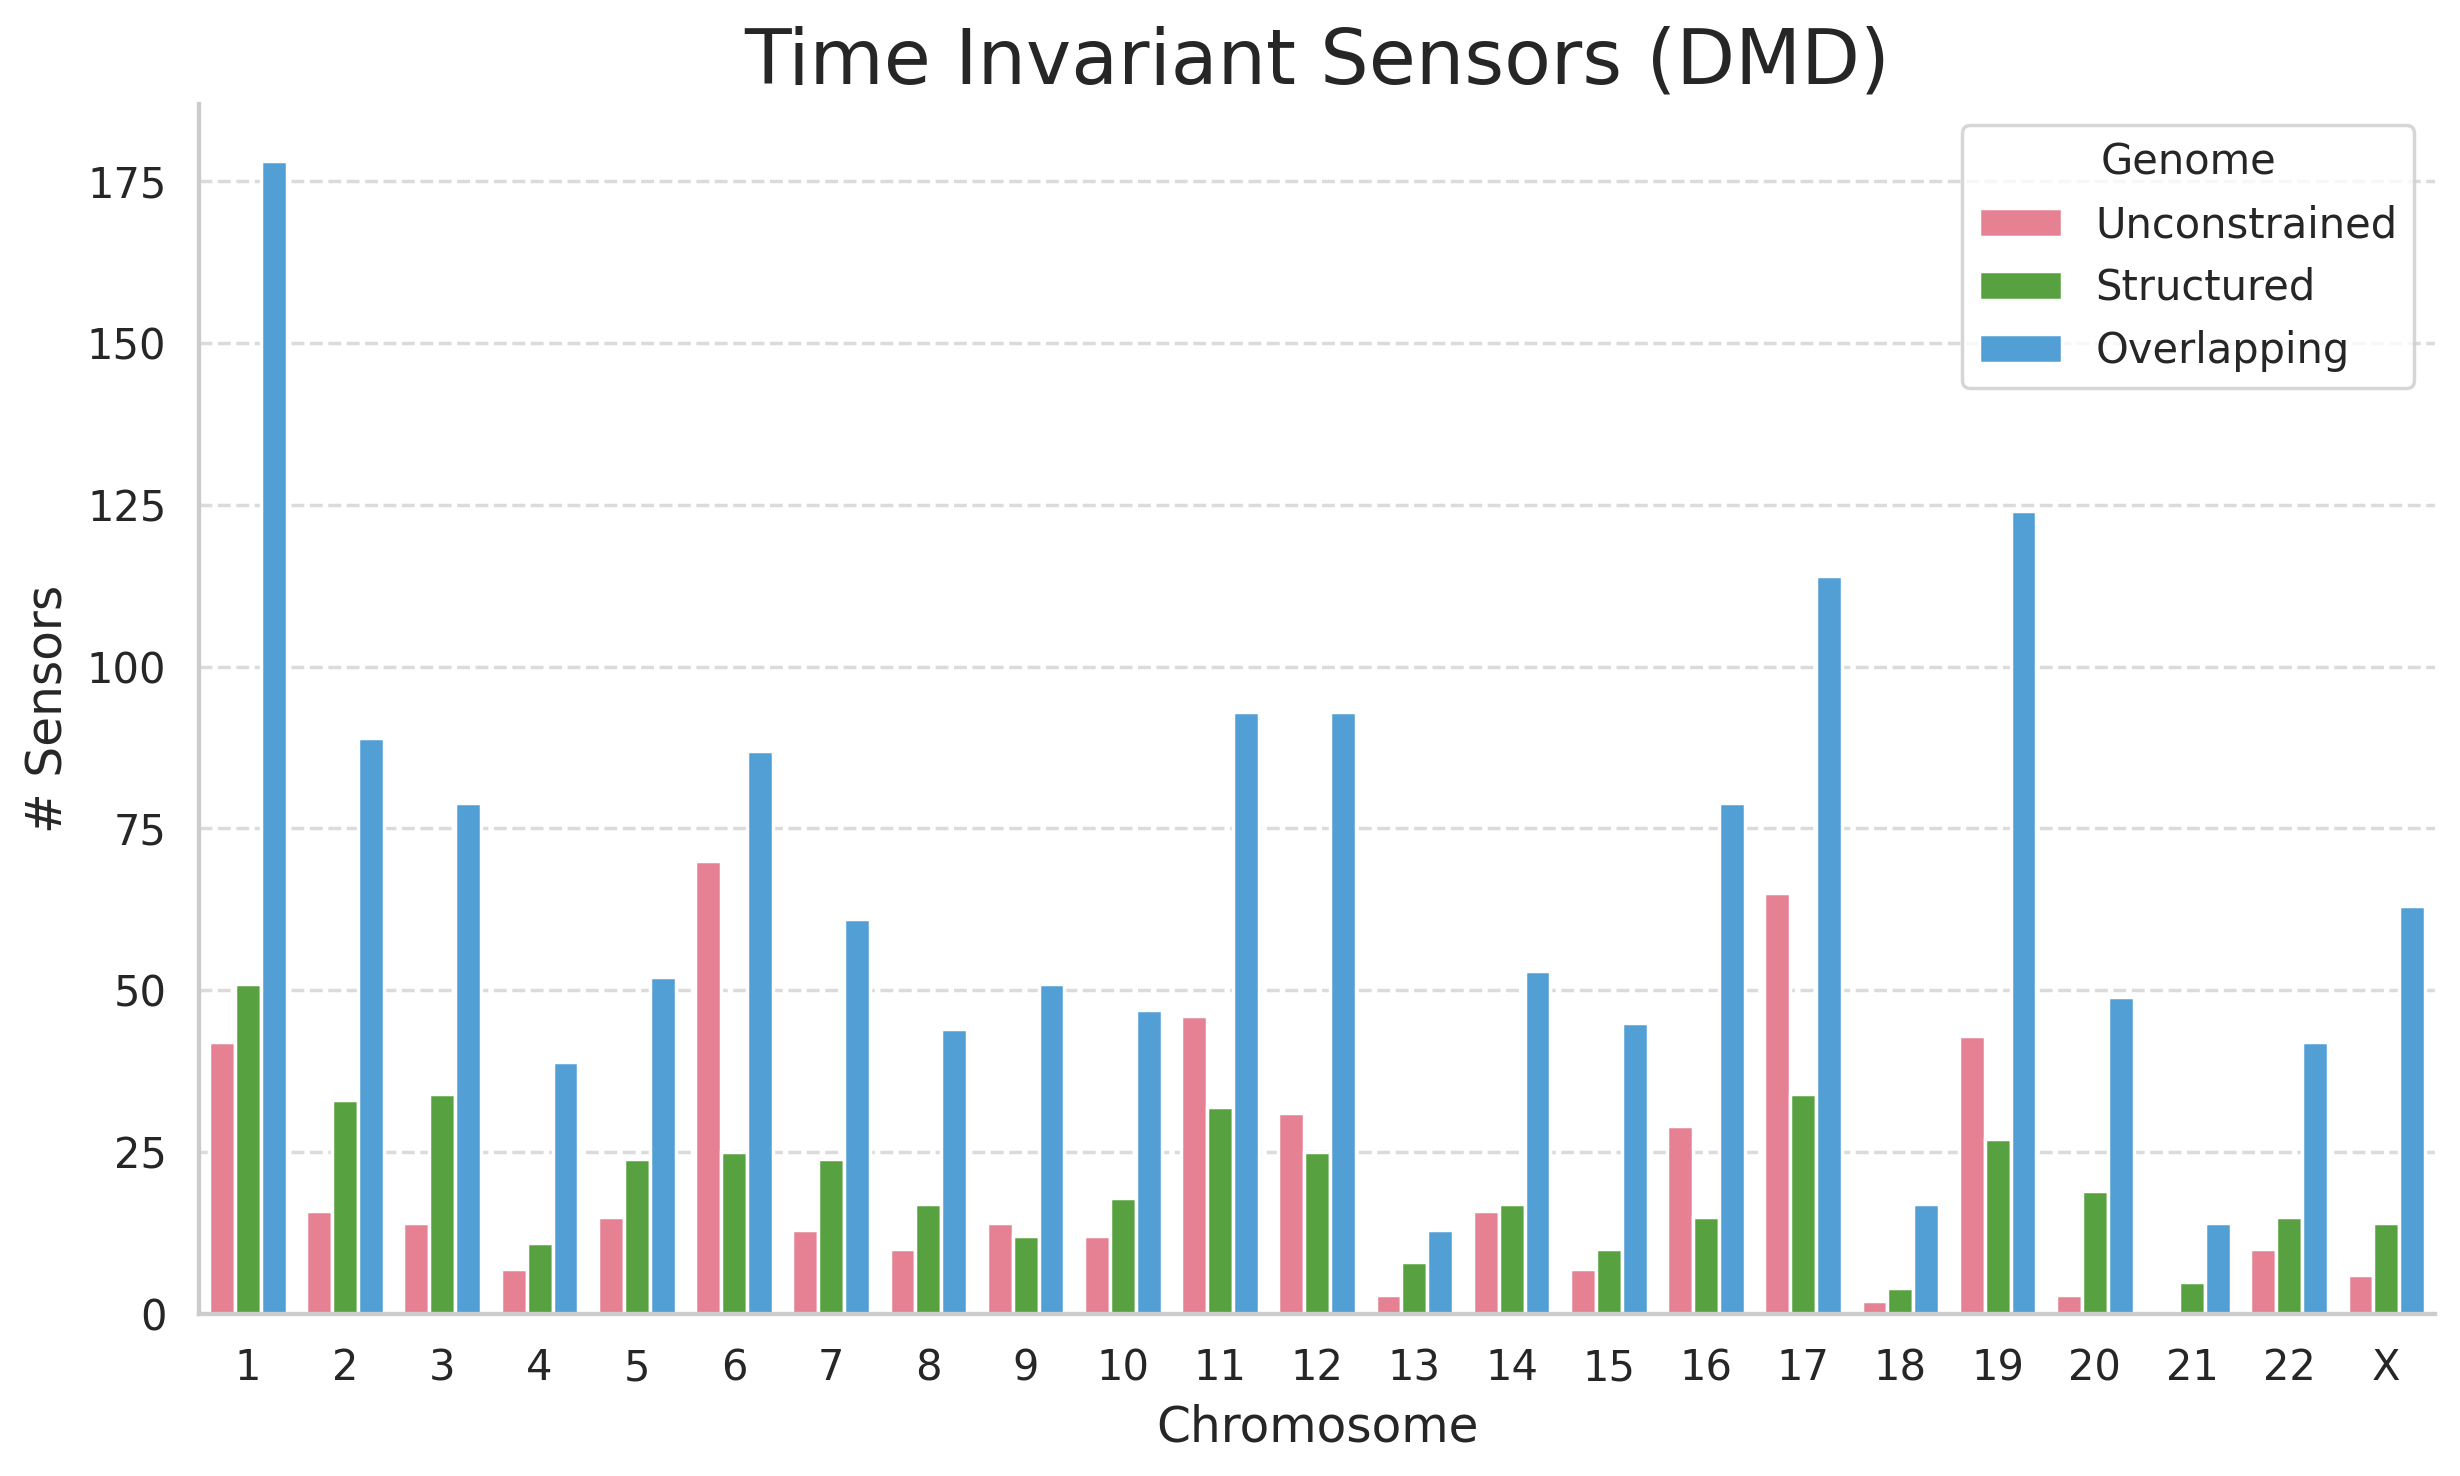

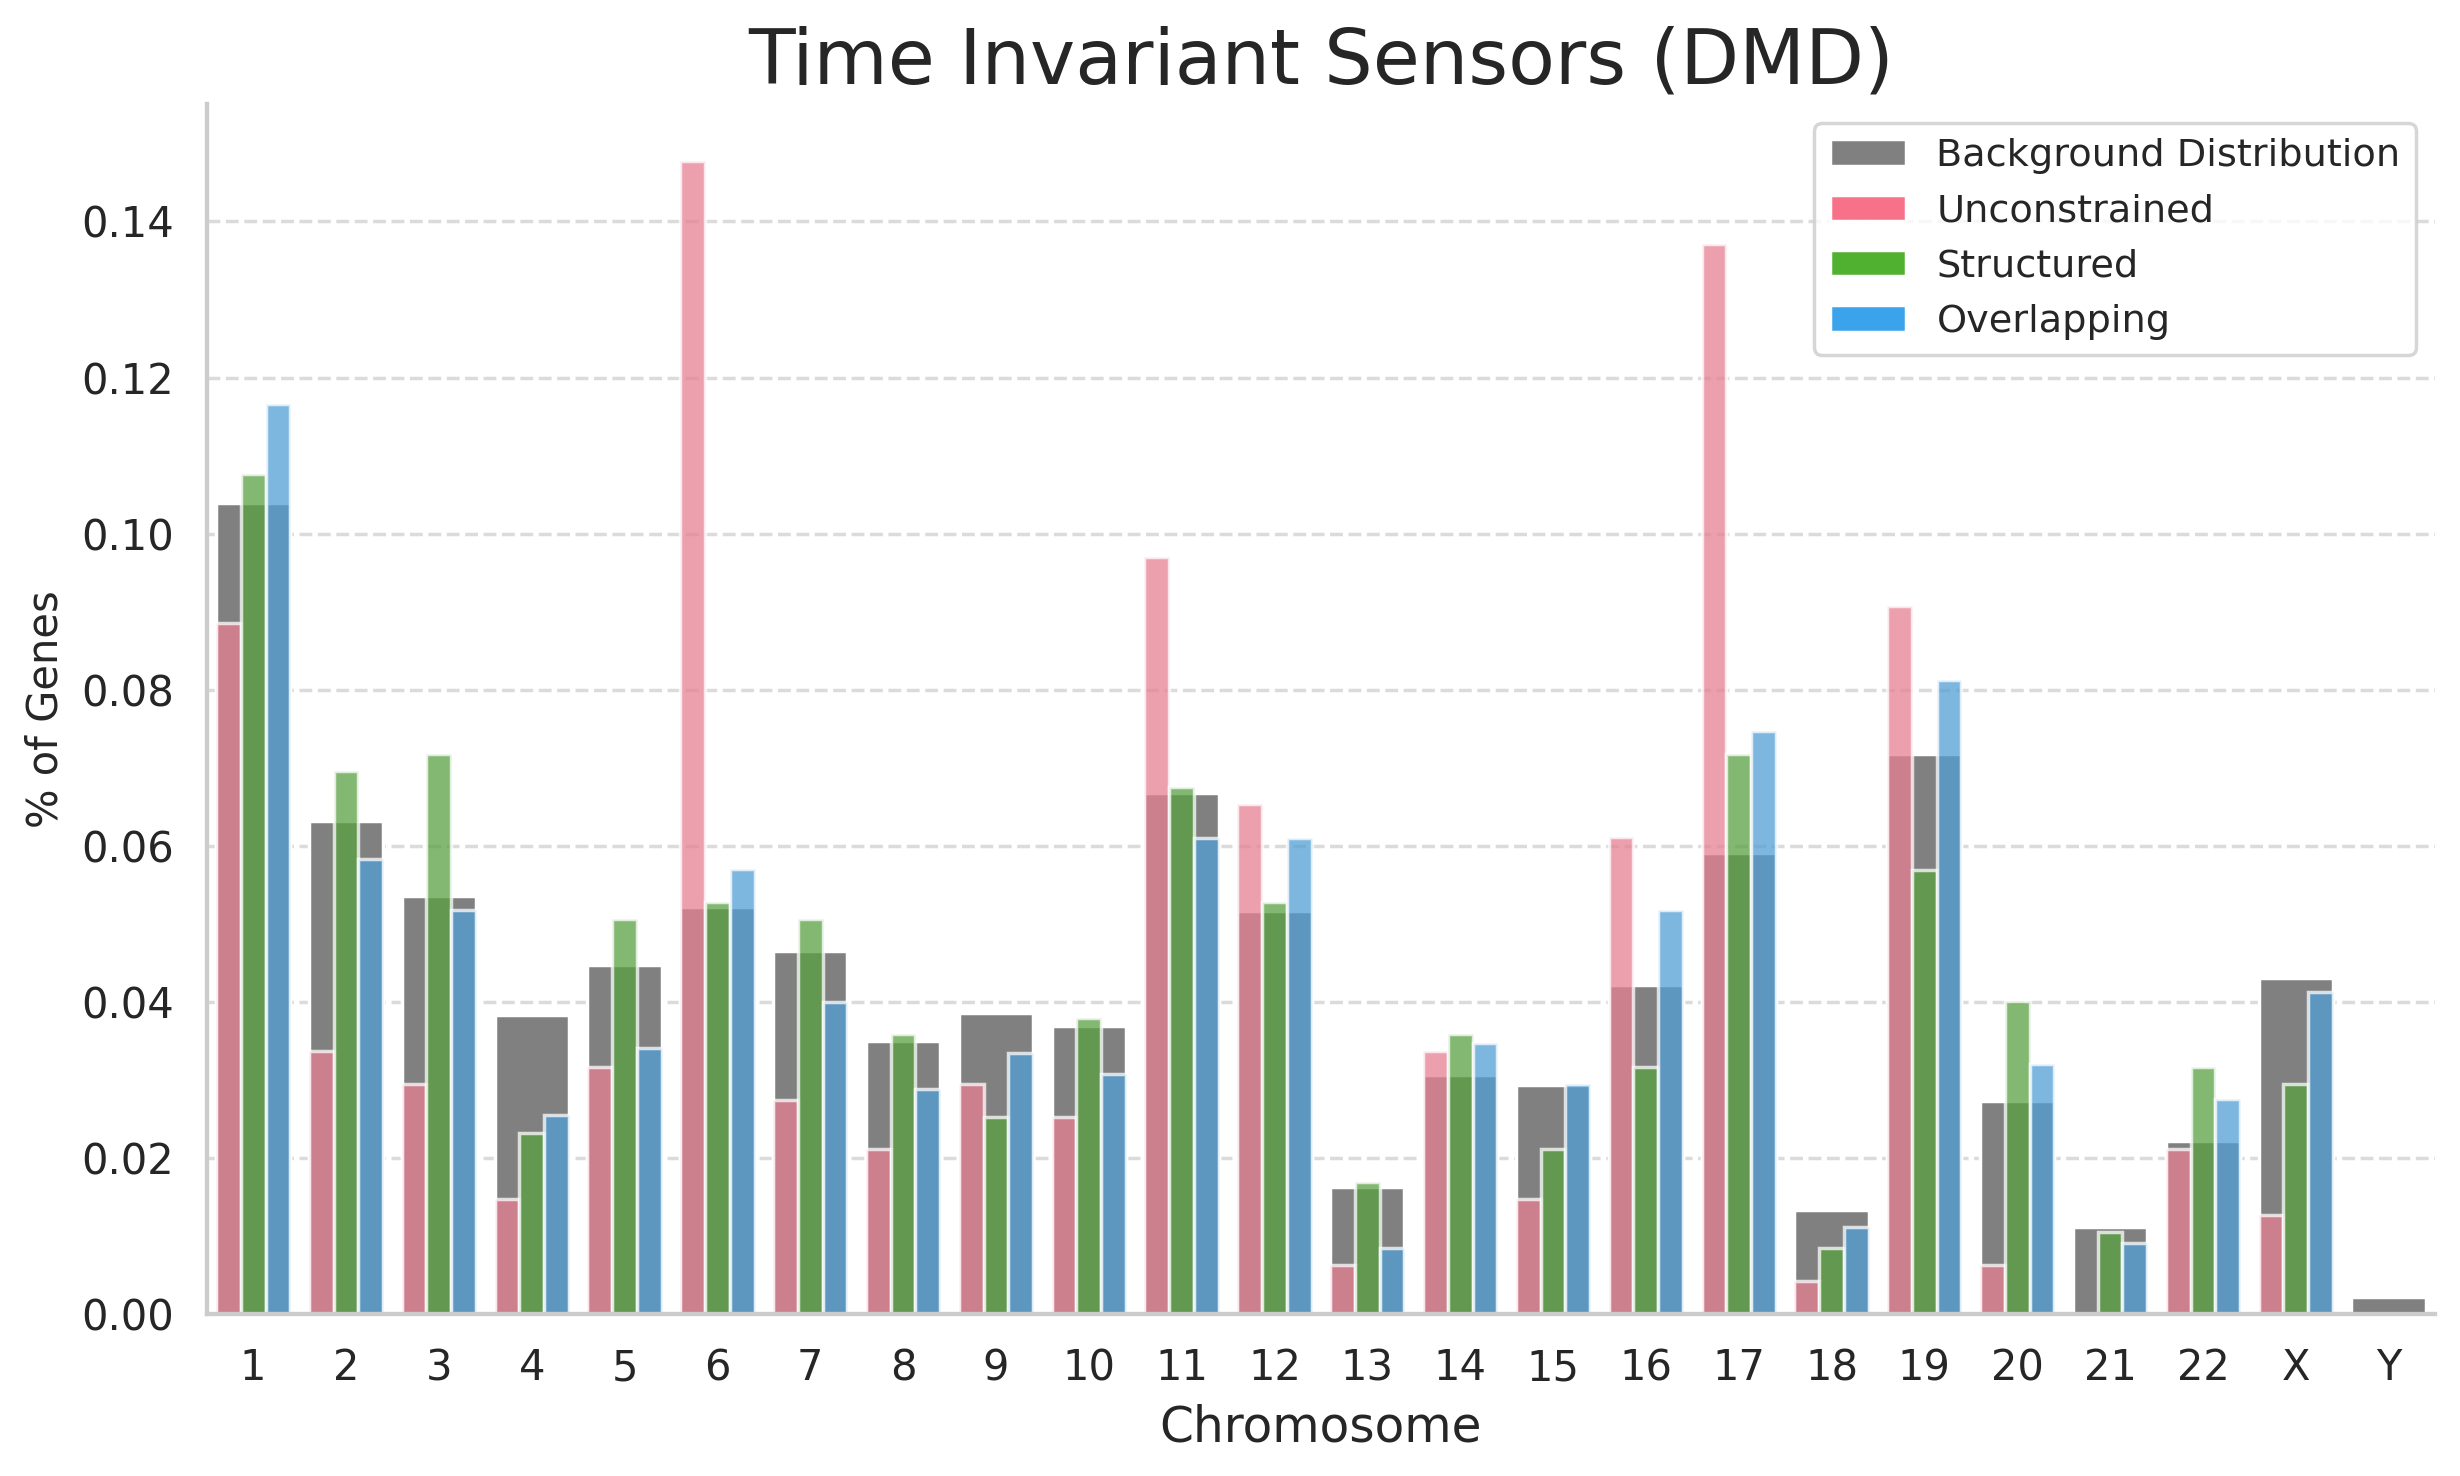

513


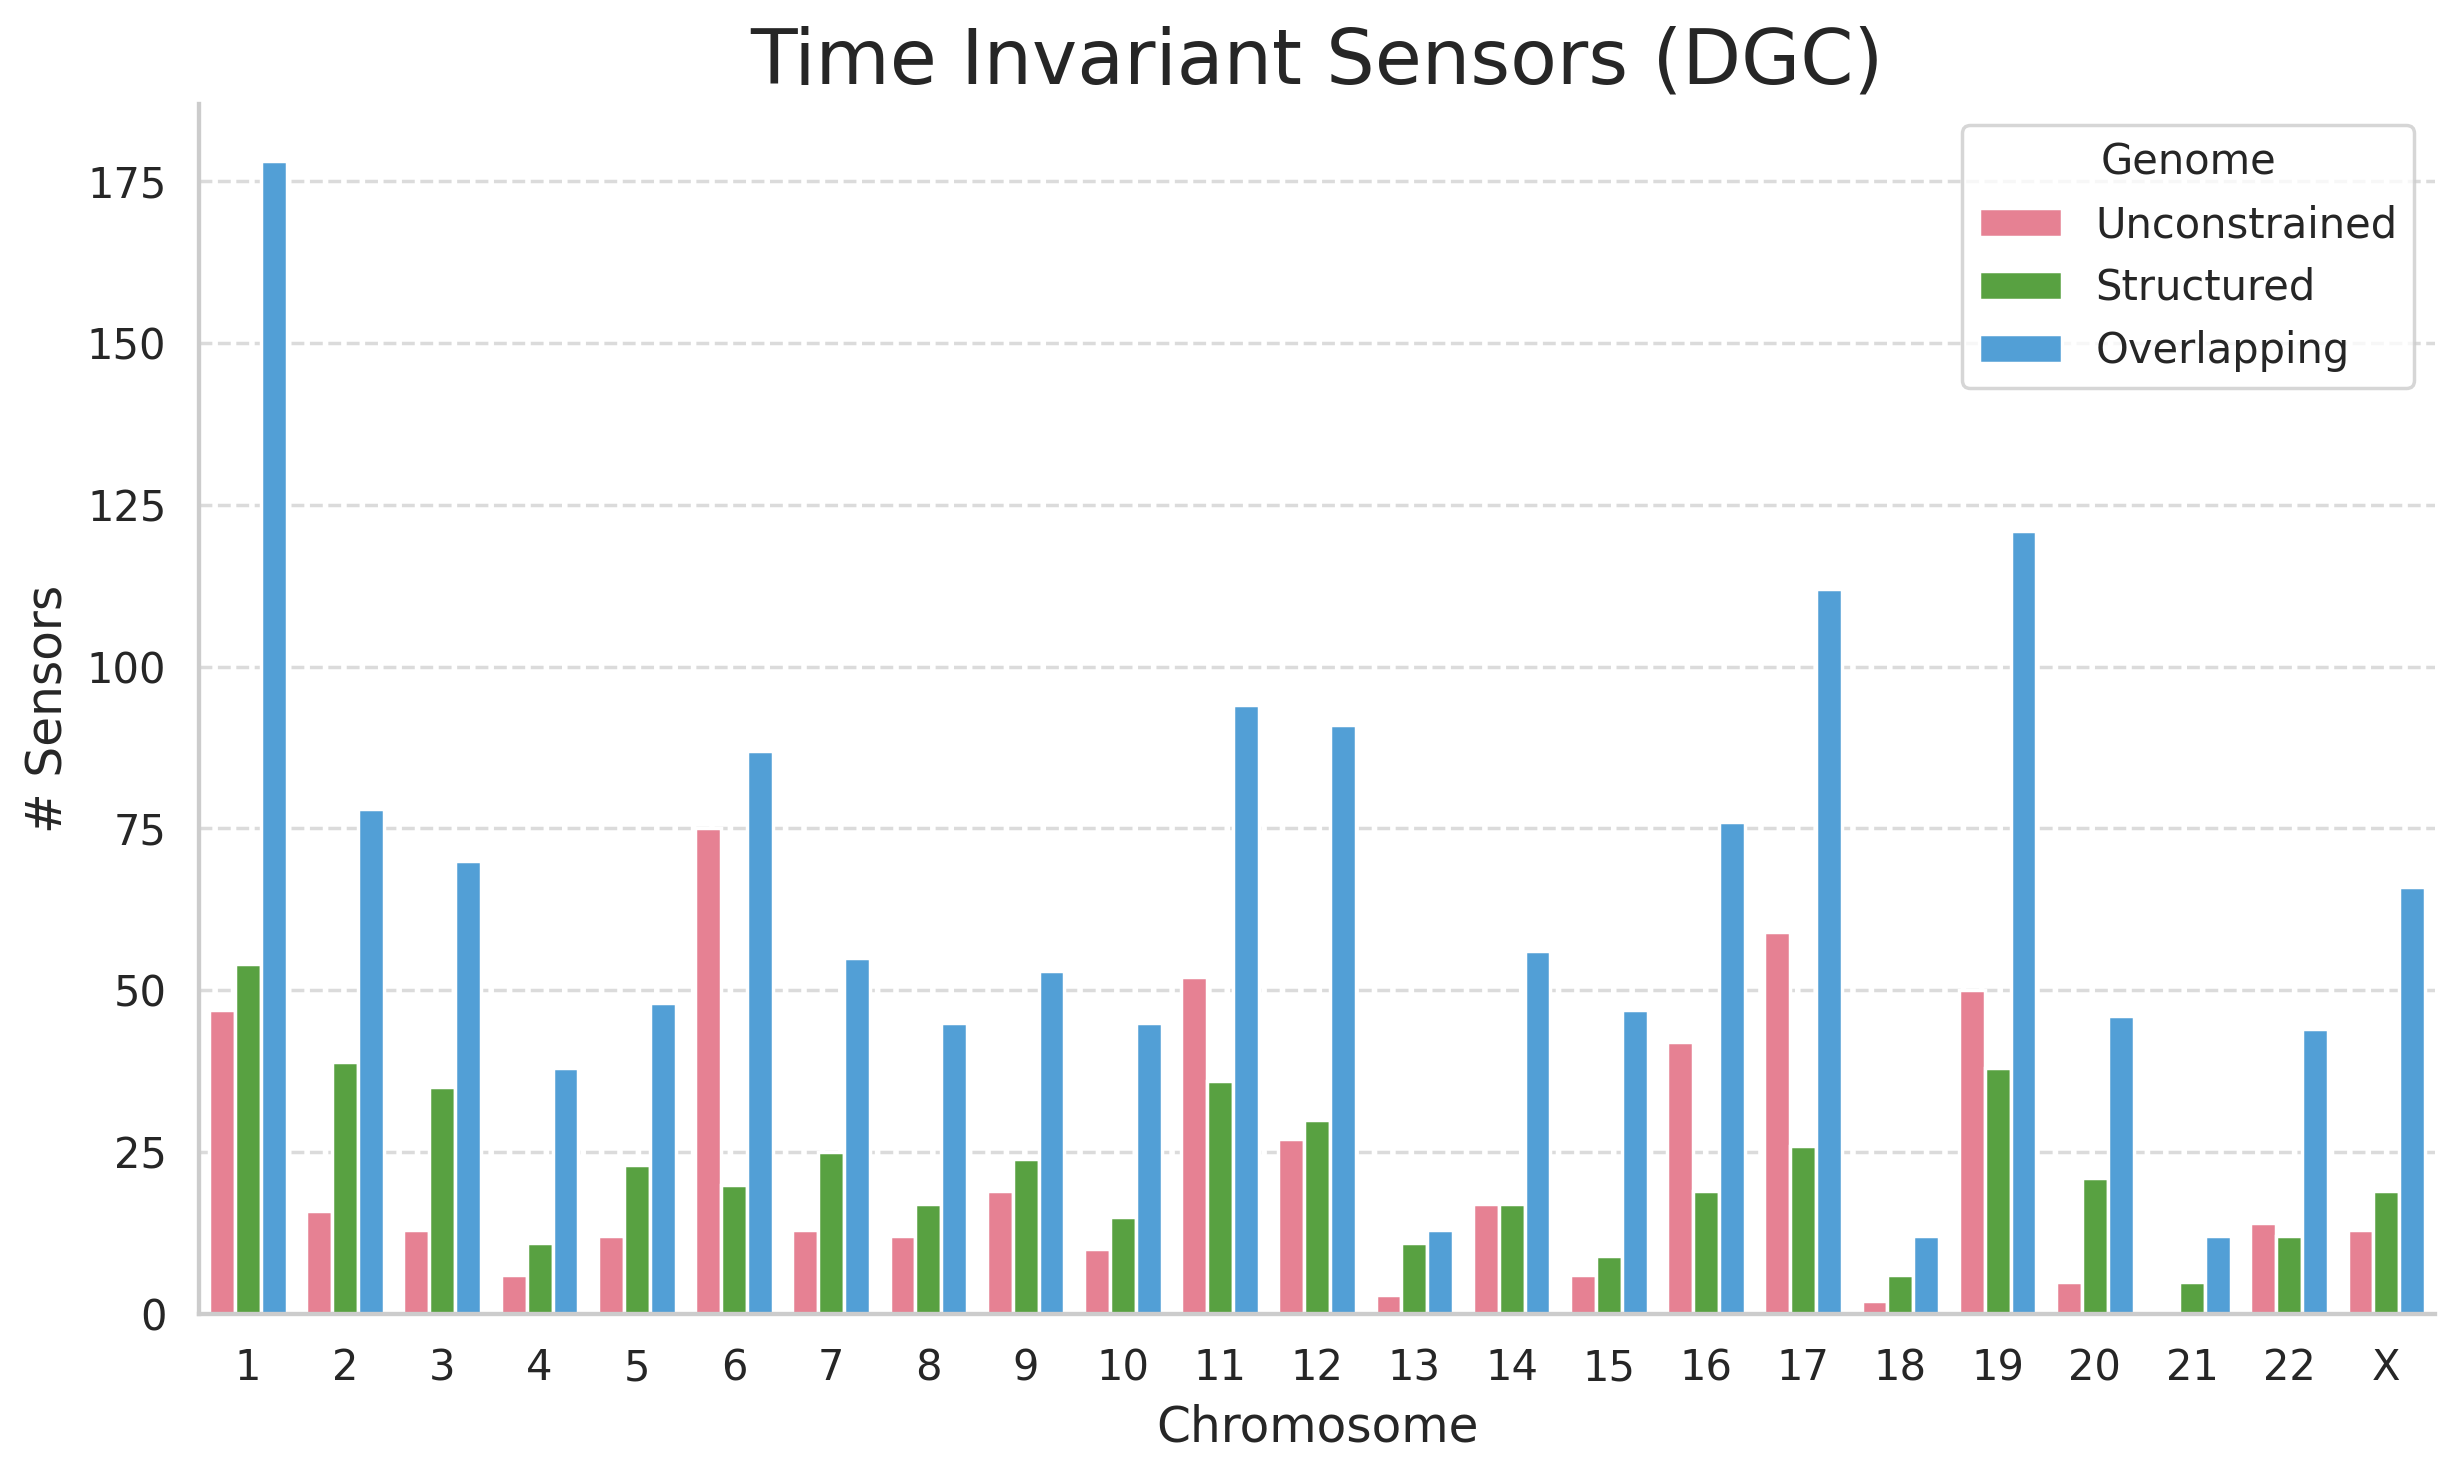

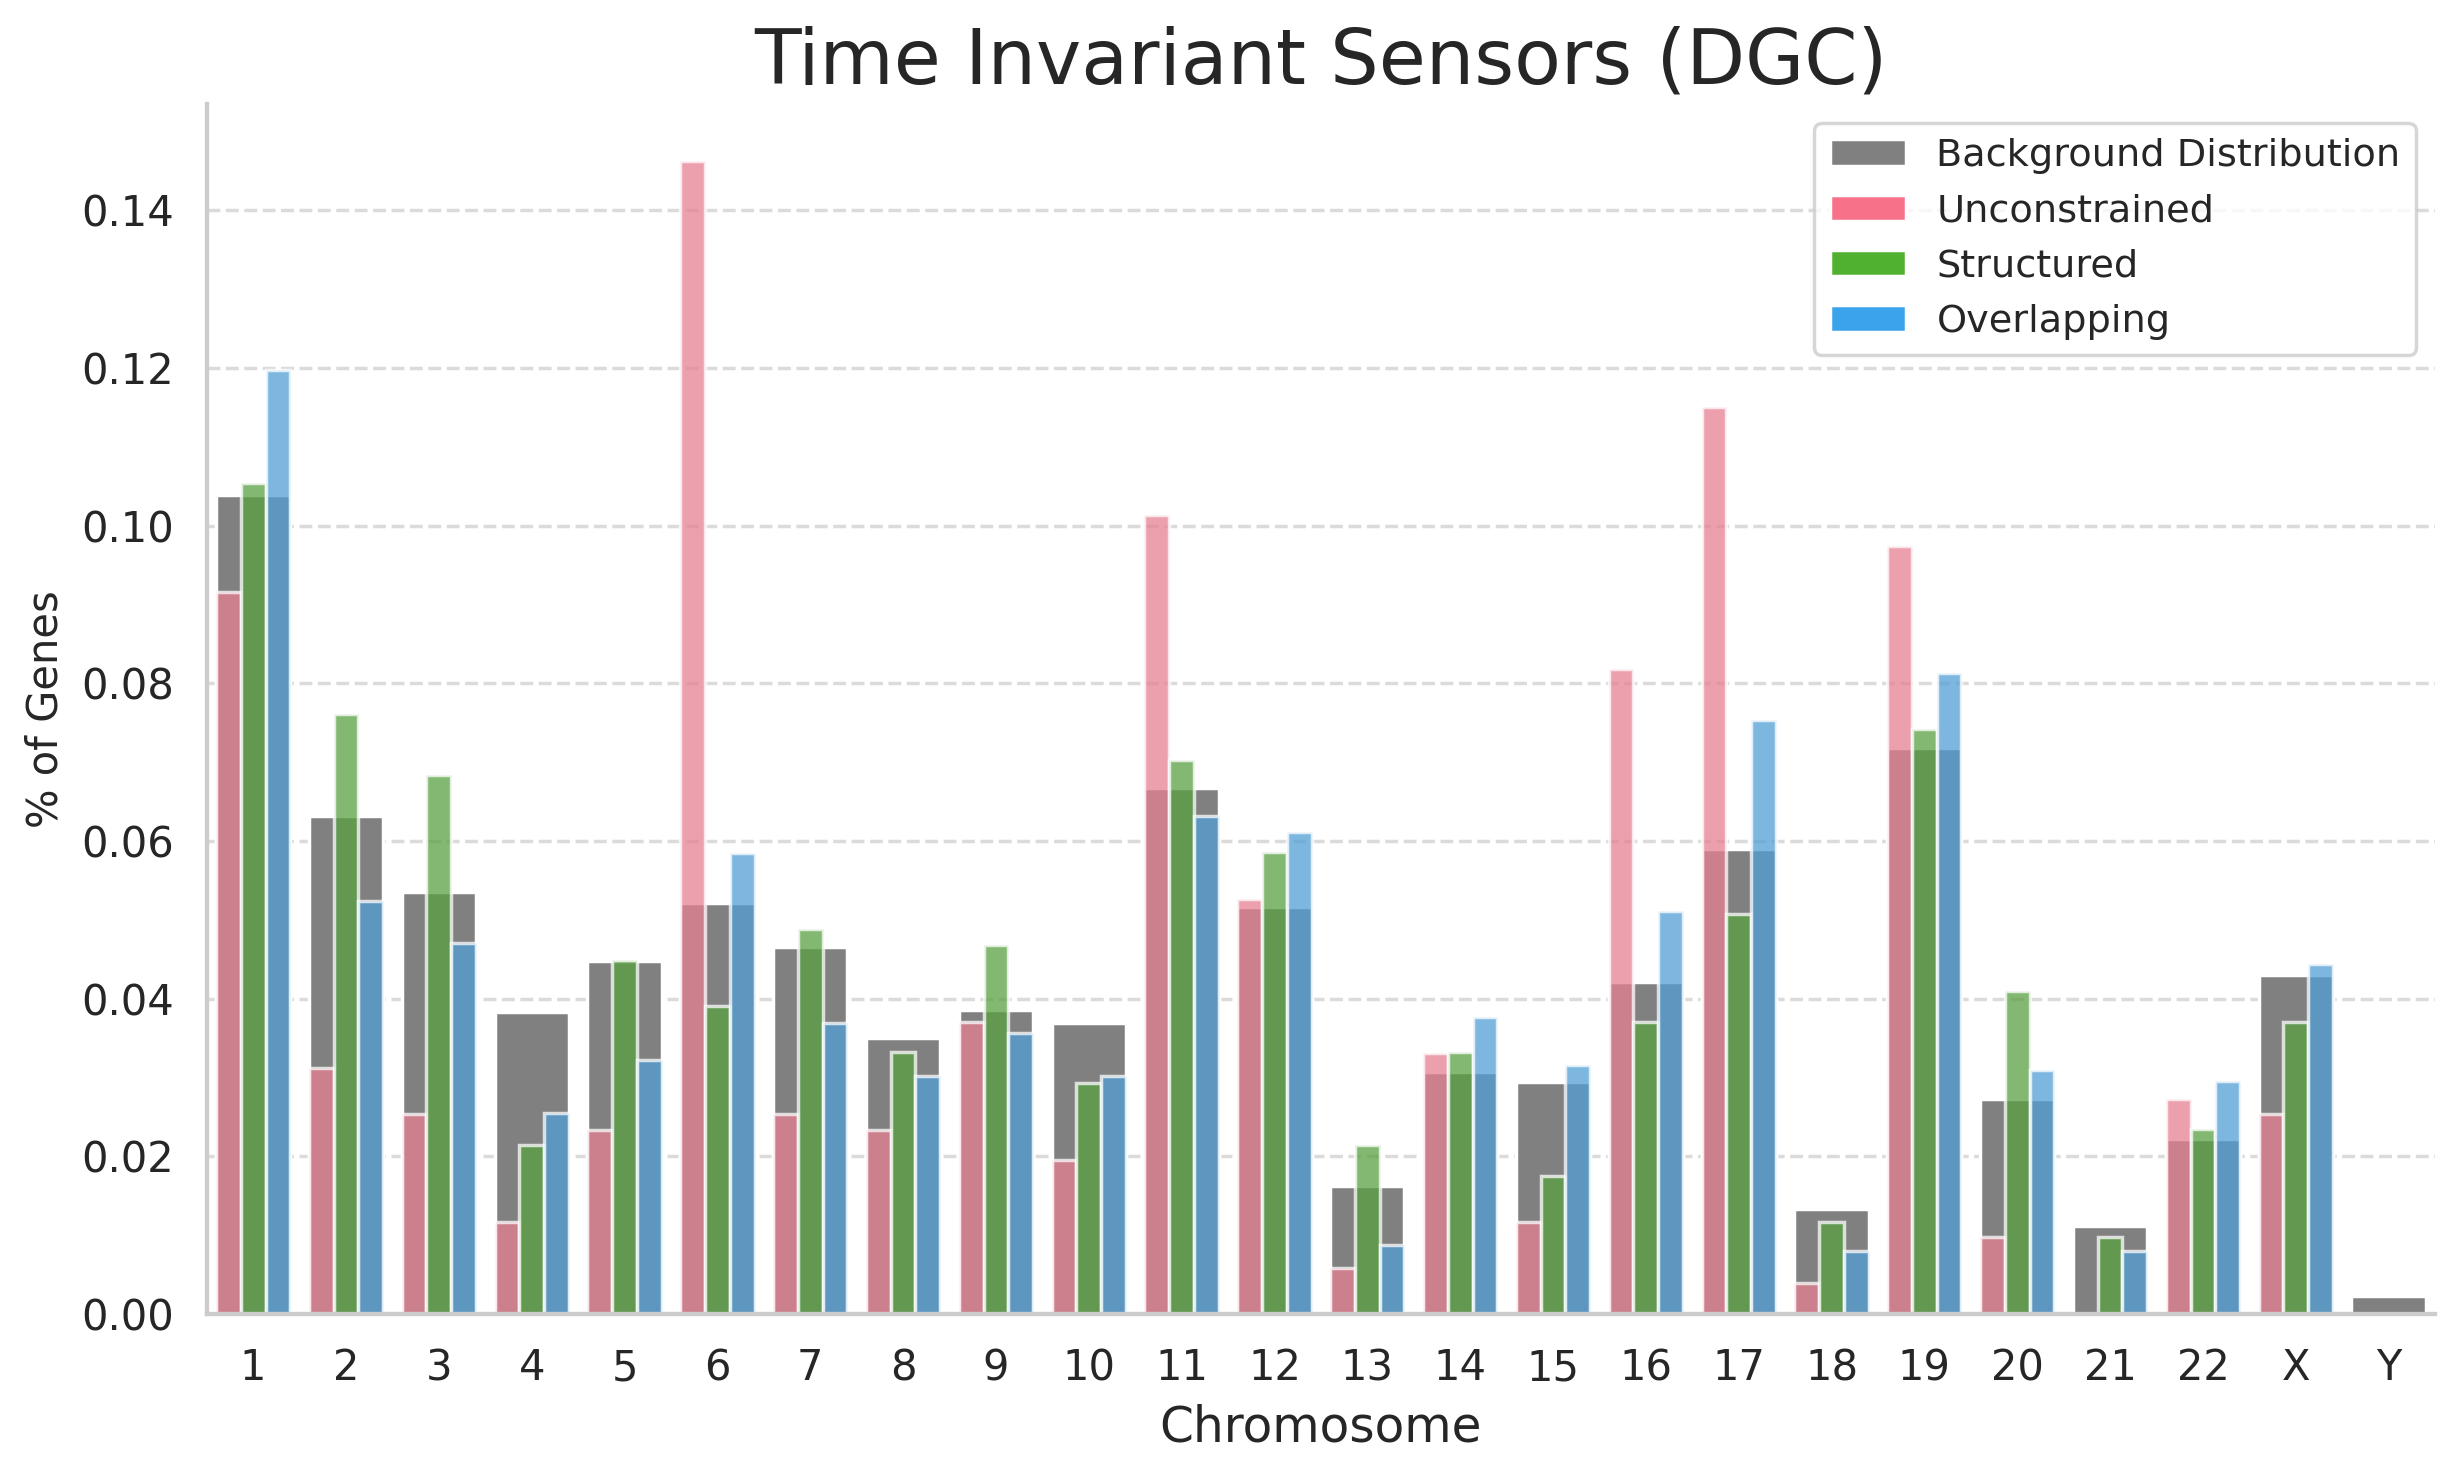

In [9]:
from matplotlib.patches import Patch
numSensors = 2000
for i in range(2):
    file1 = files[i]
    file2 = files[i+2]
    
    df1 = pd.read_excel(dataPath + file1, sheet_name='Sheet2') # free
    df2 = pd.read_excel(dataPath + file2, sheet_name='Sheet2') # structured
    
    sensors1 = df1.values
    sensors2 = df2.values
    
    sensors1 = set(list(sensors1[:numSensors].reshape(numSensors,))) # free
    sensors2 = set(list(sensors2[:numSensors].reshape(numSensors,))) # structured

    # difA = sensors1
    # difB = sensors2
    difA = sensors1.difference(sensors2) # free   
    difB = sensors2.difference(sensors1) # structured
    common = sensors1.intersection(sensors2)
    print(len(difA))
    
    chromsA = []
    for gene in difA:
        chromsA.append(gtf.loc[gene, 'chrom'])
    chromsB = []
    for gene in difB:
        if gene == 'CYB561D2':
            continue
        chromsB.append(gtf.loc[gene, 'chrom'])
    chromsC = []
    for gene in common:
        if gene == 'CYB561D2':
            continue
        chromsC.append(gtf.loc[gene, 'chrom'])
    
    # Make a plot
    res = {
        'chrom': [],
        'count': [],
        '% of Sensors': [],
        'Optimization': []
    }
    for chrom in list(np.arange(1,23)) + ['X']:
        res['chrom'].append(chrom)
        res['count'].append(chromsA.count(str(chrom)))
        res['% of Sensors'].append(chromsA.count(str(chrom)) / len(chromsA))
        res['Optimization'].append('Unconstrained')
        res['chrom'].append(chrom)
        res['count'].append(chromsB.count(str(chrom)))
        res['% of Sensors'].append(chromsB.count(str(chrom)) / len(chromsB))
        res['Optimization'].append('Structured')
        res['chrom'].append(chrom)
        res['count'].append(chromsC.count(str(chrom)))
        res['% of Sensors'].append(chromsC.count(str(chrom)) / len(chromsC))
        res['Optimization'].append('Overlapping')
    pdf = pd.DataFrame(res)

    # Plot
    palette = sns.color_palette("husl", 3)

    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6), dpi=250)
    ax = sns.barplot(data=pdf, x='chrom', y='count', hue='Optimization', palette=palette)
    plt.title('Gene Placement on Chromosomes', fontsize=16)
    plt.xlabel('Chromosome', fontsize=14)
    plt.ylabel('# Sensors', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Genome', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    sns.despine()
    plt.tight_layout()
    if i == 0:
        modelType = 'DMD'
    else:
        modelType = 'DGC'
    plt.title('Time Invariant Sensors (' + modelType + ')', fontsize=22)
#    plt.savefig('figs/structure_title_' + 'Time Invariant Sensors (' + modelType + ')' + 'counts_.png')
    plt.show()

    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6), dpi=250)
    # background distribution of genes
    ax = sns.barplot(data=cdf, x='chrom', y='% of Genes', color='gray')
    ax = sns.barplot(data=pdf, x='chrom', y='% of Sensors', hue='Optimization', palette=palette, alpha=0.75)
    plt.title('Gene Placement on Chromosomes', fontsize=16)
    plt.xlabel('Chromosome', fontsize=14)
    # plt.ylabel('# Sensors', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    legend_elements = [Patch(facecolor='gray', label='Background Distribution'),
                       Patch(facecolor=palette[0], label='Unconstrained'),
                       Patch(facecolor=palette[1], label='Structured'),
                       Patch(facecolor=palette[2], label='Overlapping'),
                      ]
    plt.legend(handles=legend_elements, loc='upper right')

    # plt.legend(title='Genome', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    sns.despine()
    plt.tight_layout()
    if i == 0:
        modelType = 'DMD'
    else:
        modelType = 'DGC'
    plt.title('Time Invariant Sensors (' + modelType + ')', fontsize=22)
#    plt.savefig('figs/structure_title_' + 'Time Invariant Sensors (' + modelType + ')' + 'pct_.png')
    plt.show()

# Combined Plots

## Version 1

513


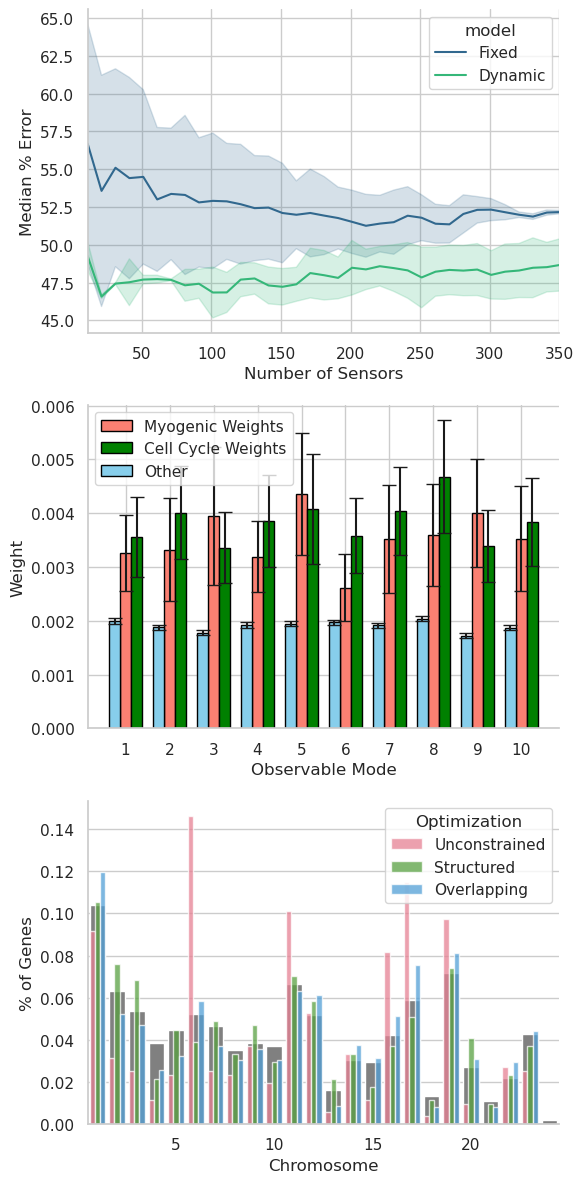

In [54]:
fig, axs = plt.subplots(3,1, dpi=100, figsize=(6,12))

# Hasnain Estimation Errors
rdf1 = pd.read_csv('/nfs/turbo/umms-indikar/Joshua/obsvArticle/results/hasnain_estimation_fixed_v_dynamic_res1.csv')
rdf2 = pd.read_csv('/nfs/turbo/umms-indikar/Joshua/obsvArticle/results/hasnain_estimation_fixed_v_dynamic_res2.csv')

pdf = rdf1[rdf1['numSensors'] > 1]
# Adjust marker size and color palette
sns.lineplot(data=pdf,
             x='numSensors',
             y='median % error',
             hue='model',
             palette='viridis',
             ax=axs[0]
            )
axs[0].set_xlabel('Number of Sensors')
axs[0].set_ylabel('Median % Error')
axs[0].set_xlim(11, 350)

# Functional Observability

# Load data from the .csv file
df = pd.read_csv('data/functional_obsv_data.csv')
x = np.arange(len(df)) + 1 # x locations for the groups
width = 0.25  # Width of the bars
Vt_means = df['Vt_means']
Vt_stds = df['Vt_serr']
myo_means = df['myo_means']
myo_stds = df['myo_serr']
cc_means = df['cc_means']
cc_stds = df['cc_serr']

# Plot bars with error bars
bars2 = axs[1].bar(x, myo_means, width, yerr=myo_stds, label='Myogenic Weights', color='salmon', capsize=5, edgecolor='black')
bars3 = axs[1].bar(x + width, cc_means, width, yerr=cc_stds, label='Cell Cycle Weights', color='green', capsize=5, edgecolor='black')
bars1 = axs[1].bar(x - width, Vt_means, width, yerr=Vt_stds, label='Other', color='skyblue', capsize=5, edgecolor='black')

# Add labels and title
axs[1].set_xlabel('Observable Mode')
axs[1].set_ylabel('Weight')
axs[1].set_xticks(x)
axs[1].legend()

# Chromosome Distribution
dataPath = '/nfs/turbo/umms-indikar/Joshua/bioObsv/notebooks/obsvArticle/dataProcessing/amit/'
files = ['sensorSet_2015_raw_full_DMD.xls',
     'sensorSet_2015_raw_full_timeVarying.xls',
     'sensorSet_2015_raw_full_DMD_structCst.xls',
     'sensorSet_2015_raw_full_timeVarying_structCst.xls'
    ]

i = 1

file1 = files[i]
file2 = files[i+2]

df1 = pd.read_excel(dataPath + file1, sheet_name='Sheet2') # free
df2 = pd.read_excel(dataPath + file2, sheet_name='Sheet2') # structured

sensors1 = df1.values
sensors2 = df2.values

sensors1 = set(list(sensors1[:numSensors].reshape(numSensors,))) # free
sensors2 = set(list(sensors2[:numSensors].reshape(numSensors,))) # structured

difA = sensors1.difference(sensors2) # free   
difB = sensors2.difference(sensors1) # structured
common = sensors1.intersection(sensors2)
print(len(difA))

chromsA = []
for gene in difA:
    chromsA.append(gtf.loc[gene, 'chrom'])
chromsB = []
for gene in difB:
    if gene == 'CYB561D2':
        continue
    chromsB.append(gtf.loc[gene, 'chrom'])
chromsC = []
for gene in common:
    if gene == 'CYB561D2':
        continue
    chromsC.append(gtf.loc[gene, 'chrom'])

# Make a plot
res = {
    'chrom': [],
    'count': [],
    '% of Sensors': [],
    'Optimization': []
}
for chrom in list(np.arange(1,23)) + ['X']:
    res['chrom'].append(chrom)
    res['count'].append(chromsA.count(str(chrom)))
    res['% of Sensors'].append(chromsA.count(str(chrom)) / len(chromsA))
    res['Optimization'].append('Unconstrained')
    res['chrom'].append(chrom)
    res['count'].append(chromsB.count(str(chrom)))
    res['% of Sensors'].append(chromsB.count(str(chrom)) / len(chromsB))
    res['Optimization'].append('Structured')
    res['chrom'].append(chrom)
    res['count'].append(chromsC.count(str(chrom)))
    res['% of Sensors'].append(chromsC.count(str(chrom)) / len(chromsC))
    res['Optimization'].append('Overlapping')
pdf = pd.DataFrame(res)

# background distribution of genes
sns.barplot(data=cdf,
            x='chrom',
            y='% of Genes',
            color='gray',
            ax=axs[2]
           )
sns.barplot(data=pdf,
            x='chrom',
            y='% of Sensors',
            hue='Optimization',
            palette=palette,
            alpha=0.75,
            ax=axs[2]
           )
axs[2].set_xlabel('Chromosome')
axs[2].set_xticks(axs[2].get_xticks()[4::5])

plt.tight_layout()
sns.despine()
plt.savefig('results-v0.png')
plt.show()

